In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })

import sys

In [2]:
from cpymad.madx import Madx

import sixtracklib as stl
import pysixtrack

In [3]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [4]:
madx = Madx(stdout=sys.stdout)
madx.options.echo = False
madx.options.warn = True
madx.options.info = True


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2021.12.02 15:02:12      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madx.call('./SIS100RING_COLD.seq')

++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy


In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [8]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)

True

In [9]:
madx.call('./SIS100_VIRTUAL_SLOW.str')

In [10]:
madx.use(sequence='sis100ring')

In [11]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='QUADRUPOLE',
    slice_='9',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='9',
)

assert madx.command.makethin(
    makedipedge=True,
    style='teapot',
    sequence='sis100ring',
)

makethin: style chosen : teapot
makethin: slicing sequence : sis100ring


In [12]:
madx.use(sequence='sis100ring')

In [13]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0      0.00497433219        14.17857575 

                q1                dq1            betxmax              dxmax 
       17.30946086       -35.56263243        19.70862817        2.655637569 

             dxrms             xcomax             xcorms                 q2 
       1.607893055                  0                  0        17.39944561 

               dq2            betymax              dymax              dyrms 
      -35.57285912        19.78572019                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [14]:
madx.input('''
    eoption, add=false, seed=1; 
    select, flag=error, clear;
    select, flag=error, pattern="qd11\.\.slice";
    select, flag=error, pattern="qd12\.\.slice";
    '''
)

True

In [15]:
madx.input('SELECT, FLAG = ERROR, FULL;')

True

In [16]:
madx.input('''
EFCOMP, radius=0.04, order=1, dknr:={0, 0, 0, 1e-4}, dksr:={0, 0, 0, 1e-18}; 
!need negligible a4 due to bug in pysixtrack
''')

Assigned field errors to 2980 elements


True

In [17]:
madx.input('ESAVE, file=err;')

True

In [18]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0      0.00497433219        14.17857575 

                q1                dq1            betxmax              dxmax 
       17.30946086       -35.56263243        19.70862817        2.655637569 

             dxrms             xcomax             xcorms                 q2 
       1.607893055                  0                  0        17.39944561 

               dq2            betymax              dymax              dyrms 
      -35.57285912        19.78572019                 -0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [19]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, apply_madx_errors=True
)

In [20]:
pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

In [21]:
quads = [el for el, eln in zip(pysixtrack_elements.elements, pysixtrack_elements.element_names) if 'qd' in eln]

In [22]:
quads[0]

Multipole(knl=[0.0, -0.028957920152517122, 0.0, -0.01085922005719392], ksl=[0.0, 0.0, 0.0, -1.0859220057193921e-16], hxl=0.0, hyl=0.0, length=0.13833333333333334)

In [23]:
elements = stl.Elements.from_line(pysixtrack_elements)

In [24]:
# nturns = 2**10
# elements.BeamMonitor(num_stores=nturns);

In [25]:
particles = stl.Particles.from_ref(
    150, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

In [26]:
init_grid = np.linspace(0, 1e-2, 51, endpoint=True)[1:]
particles.x[:50] += init_grid
particles.y[50:100] += init_grid

particles.x[100:150] += 1e-10
particles.y[100:150] += init_grid

In [27]:
trackjob = stl.TrackJob(elements, particles, device=None)

In [28]:
trackjob.track_until(1) #nturns)
trackjob.collect()

In [29]:
def rectify(tune):
#     if tune < 0.5:
#         return 1 - tune
    return tune

def compute_J(u, up, beta=twiss['betx'][0], alpha=twiss['alfx'][0]):
    a = alpha
    b = beta
    g = (1 + a**2) / b
    
    return 0.5 * (g * u**2 + 2 * a * u * up + b * up**2)

def compute_oneturn_tune(u, up, dp=None, beta=twiss['betx'][0], alpha=twiss['alfx'][0]):
    u = u.astype(float)
    up = up.astype(float)
    if dp is None:
        dp = np.zeros_like(u)
    dp = dp.astype(float)
    
    a = alpha
    b = beta
    g = (1 + a**2) / b
    
    J = compute_J(u, up, b, a)
    
    phi0 = np.angle(
        (u[0] / np.sqrt(b) / np.sqrt(2 * J[0])) +
        1j * ((u[0] * a / np.sqrt(b) + up[0] * np.sqrt(b)) / np.sqrt(2 * J[0]))
    )

    phi1 = np.angle(
        (u[1] / np.sqrt(b) / np.sqrt(2 * J[1])) +
        1j * ((u[1] * a / np.sqrt(b) + up[1] * np.sqrt(b)) / np.sqrt(2 * J[1]))
    )
    
    tunes = list(map(rectify, np.abs(phi1 - phi0) / (2 * np.pi)))
    
    return np.array(tunes)

In [30]:
Qx_x = compute_oneturn_tune(
    np.vstack((init_grid, particles.x[:50])),
    np.vstack((np.zeros(50), particles.px[:50])),
    beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Qx_x

array([0.30946106, 0.30946165, 0.30946264, 0.30946403, 0.30946581,
       0.30946799, 0.30947056, 0.30947353, 0.30947689, 0.30948065,
       0.30948481, 0.30948936, 0.30949431, 0.30949965, 0.30950539,
       0.30951153, 0.30951806, 0.30952498, 0.30953231, 0.30954002,
       0.30954814, 0.30955665, 0.30956555, 0.30957486, 0.30958455,
       0.30959465, 0.30960514, 0.30961602, 0.3096273 , 0.30963898,
       0.30965105, 0.30966352, 0.30967638, 0.30968964, 0.3097033 ,
       0.30971735, 0.3097318 , 0.30974664, 0.30976188, 0.30977751,
       0.30979354, 0.30980997, 0.30982679, 0.30984401, 0.30986162,
       0.30987963, 0.30989804, 0.30991684, 0.30993604, 0.30995563])

In [31]:
Qy_y = compute_oneturn_tune(
    np.vstack((init_grid, particles.y[50:100])),
    np.vstack((np.zeros(50), particles.py[50:100])),
    beta=twiss['bety'][0], alpha=twiss['alfy'][0])
Qy_y

array([0.39944548, 0.3994451 , 0.39944445, 0.39944355, 0.39944239,
       0.39944097, 0.39943929, 0.39943736, 0.39943516, 0.39943271,
       0.39943001, 0.39942704, 0.39942381, 0.39942033, 0.39941659,
       0.39941259, 0.39940833, 0.39940382, 0.39939905, 0.39939402,
       0.39938873, 0.39938318, 0.39937738, 0.39937131, 0.39936499,
       0.39935842, 0.39935158, 0.39934449, 0.39933713, 0.39932952,
       0.39932165, 0.39931353, 0.39930514, 0.3992965 , 0.3992876 ,
       0.39927844, 0.39926903, 0.39925935, 0.39924942, 0.39923923,
       0.39922879, 0.39921808, 0.39920712, 0.3991959 , 0.39918442,
       0.39917268, 0.39916068, 0.39914843, 0.39913592, 0.39912315])

In [32]:
Qx_y = compute_oneturn_tune(
    np.vstack((init_grid, particles.x[100:150])),
    np.vstack((np.zeros(50), particles.px[100:150])),
    beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Qx_y

array([0.30946087, 0.30946089, 0.30946093, 0.30946098, 0.30946105,
       0.30946114, 0.30946123, 0.30946135, 0.30946148, 0.30946162,
       0.30946178, 0.30946196, 0.30946214, 0.30946235, 0.30946257,
       0.3094628 , 0.30946306, 0.30946332, 0.3094636 , 0.3094639 ,
       0.30946421, 0.30946453, 0.30946488, 0.30946523, 0.3094656 ,
       0.30946599, 0.30946639, 0.30946681, 0.30946724, 0.30946769,
       0.30946815, 0.30946863, 0.30946913, 0.30946963, 0.30947016,
       0.3094707 , 0.30947125, 0.30947182, 0.3094724 , 0.309473  ,
       0.30947362, 0.30947425, 0.30947489, 0.30947555, 0.30947623,
       0.30947692, 0.30947763, 0.30947835, 0.30947909, 0.30947984])

In [33]:
# for x in trackjob.output.particles[0].x.reshape((nturns, 150)).T[:50]:
#     plt.plot(1 - np.fft.rfftfreq(nturns), np.abs(np.fft.rfft(x)) / max(np.abs(np.fft.rfft(x))))
# plt.xlim(0.87, 0.89)

In [34]:
# for y in trackjob.output.particles[0].y.reshape((nturns, 150)).T[50:100]:
#     plt.plot(1 - np.fft.rfftfreq(nturns), np.abs(np.fft.rfft(y)) / max(np.abs(np.fft.rfft(y))))
# plt.xlim(0.79, 0.81)

In [35]:
Jx = compute_J(init_grid, np.zeros(50), beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Jy = compute_J(init_grid, np.zeros(50), beta=twiss['bety'][0], alpha=twiss['alfy'][0])

array([32.08789717,  0.30946086])

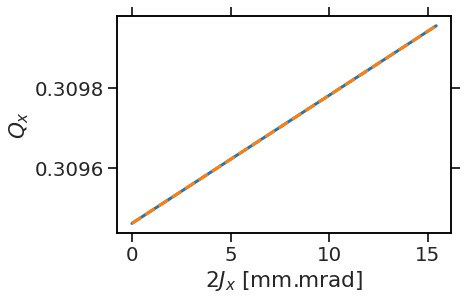

In [36]:
plt.plot(2 * Jx * 1e6, Qx_x)
fit = np.polyfit(2 * Jx, Qx_x, deg=1)
plt.plot(2 * Jx * 1e6, np.poly1d(fit)(2 * Jx), ls='--')
plt.ticklabel_format(style='plain')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('$2J_x$ [mm.mrad]')
plt.ylabel('$Q_x$')
fit

array([-20.86175719,   0.39944561])

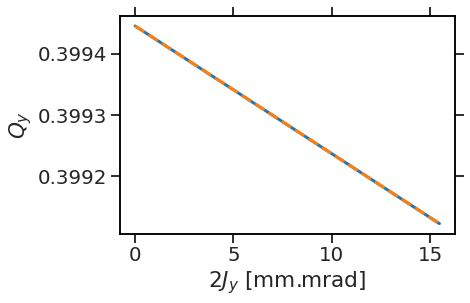

In [37]:
plt.plot(2 * Jy * 1e6, Qy_y)
fit = np.polyfit(2 * Jy, Qy_y, deg=1)
plt.plot(2 * Jy * 1e6, np.poly1d(fit)(2 * Jy), ls='--')
plt.xlabel('$2J_y$ [mm.mrad]')
plt.ylabel('$Q_y$')
fit

array([1.22741434, 0.30946086])

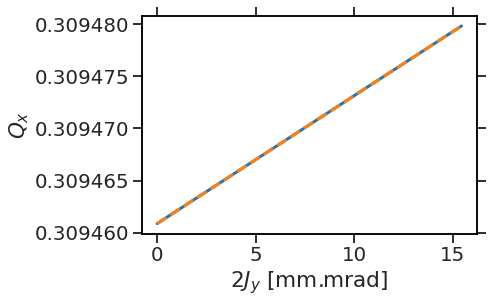

In [38]:
plt.plot(2 * Jy * 1e6, Qx_y)
fit = np.polyfit(2 * Jy, Qx_y, deg=1)
plt.plot(2 * Jy * 1e6, np.poly1d(fit)(2 * Jy), ls='--')
plt.ticklabel_format(style='plain')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('$2J_y$ [mm.mrad]')
plt.ylabel('$Q_x$')
fit